In [1]:
import subprocess
import sys
import os
import re
import atexit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import datetime as dt
from sklearn.preprocessing import OneHotEncoder

# Librería para evitar mensajes de warning al ejecutar código Python
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore')

# Librería para cronometrar tiempos de ejecución
#import time
#start_time = time.time()

# Definición de constantes
FIRST_DATE = dt.datetime(2012,12,1)
LAST_DATE = dt.datetime(2015,12,31)

## Carga de datos

In [2]:
# Diccionario con features y sus tipos
dtype = {'DeviceID':str, 'Fault_Code_Type_1':str, 'Fault_Code_Type_2':str, 'Fault_Code_Type_3':str, 'Fault_Code_Type_4':str}

# Carga del dataset teniendo en cuenta el diccionario definido y el formato de la feature de tipo fecha
df = pd.read_csv('sampledata.csv', sep=',', dtype=dtype, parse_dates=['Date'], infer_datetime_format=True)

## Preprocesamiento de datos

In [3]:
# Verificación del dataframe: dimesiones y tipo de sus features
print('Dimensiones del dataframe: {}'.format(df.shape))
print('\nTipo de las features:\n{}'.format(df.dtypes))

Dimensiones del dataframe: (2085102, 172)

Tipo de las features:
DeviceID                     object
Date                 datetime64[ns]
Categorical_1                 int64
Categorical_2                 int64
Categorical_3                 int64
Categorical_4                 int64
Problem_Type_1                int64
Usage_Count_1                 int64
Usage_Count_2                 int64
Problem_Type_2                int64
Problem_Type_3                int64
Problem_Type_4                int64
Warning_1.2                   int64
Warning_1.3                   int64
Warning_1.4                   int64
Warning_1.5                   int64
Warning_1.6                   int64
Warning_1.7                   int64
Warning_1.8                   int64
Warning_1.9                   int64
Warning_1.10                  int64
Warning_1.11                  int64
Warning_1.12                  int64
Warning_1.13                  int64
Warning_1.14                  int64
Warning_1.15                  int64

#### Definición de las features:
* ***DeviceID***: identificador de la máquina.
* ***Date***: fecha del registro (fila).
* ***Categorical_X***: variables categóricas de la máquina (x4).
* ***Problem_Type_X***: número total de problemas de un tipo reportados por la máquina durante un día (x4).
* ***Usage_Count_X***: número total de veces que la máquina ha sido usada en cada modo de funcionamiento (x2).
* ***Warning_X***: número total de avisos reportados por la máquina durante un día (x147).
* ***Error_Count_X***: número total de errores de un tipo reportados por la máquina durante un día (x8).
* ***Fault_Code_Type_X***: tipo de código de fallo reportado por la máquina durante un día (x4).
* ***ProblemReported***: feature objetivo (a predecir), que indica si la máquina tuvo un problema durante un día.

In [4]:
# Borrado de filas duplicadas cuyos valores coincidan en 'DeviceID' y 'Date'
df = df.drop_duplicates(['DeviceID', 'Date'])

# Borrado de filas en las que no exista valor en 'DeviceID' o 'Date'
df = df.dropna(how='any', subset=['DeviceID', 'Date'])

# Instrucción para hacer que la dupla 'DeviceID' y 'Date' sean los índices del dataframe
#df = df.set_index(['DeviceID', 'Date'])

# Creación de las features 'Day', 'Month' y 'Year', extraidas de la feature 'Date'
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [5]:
# Definición de grupos de features: date, categorical, numeric
datetime_features = ['Date', 'Day', 'Month', 'Year']
categorical_features = ['DeviceID', 'Categorical_1', 'Categorical_2', 'Categorical_3', 'Categorical_4',
                        'Fault_Code_Type_1', 'Fault_Code_Type_2', 'Fault_Code_Type_3', 'Fault_Code_Type_4']
warning_type1_features = [feature for feature in df.columns if feature.startswith('Warning_1')]
warning_type2_features = [feature for feature in df.columns if feature.startswith('Warning_2')]
warning_features = warning_type1_features + warning_type2_features
numeric_features = list(set(df.columns) - set(datetime_features) - set(categorical_features))

# Tratamiento de datos no registrados: valor 0 para features numéricas
values = dict(zip(numeric_features, np.zeros(len(numeric_features))))
df = df.fillna(value=values)

# Tratamiento de datos no registrados: valor 'Unknown' para features categóricas
values = dict(zip(categorical_features, ['Unknown' for k in range(len(categorical_features))]))
df = df.fillna(value=values)

# Visualización de los 5 primeros registros del dataframe
df.head()

,DeviceID,Date,Categorical_1,Categorical_2,Categorical_3,Categorical_4,Problem_Type_1,Usage_Count_1,Usage_Count_2,Problem_Type_2,...,Error_Count_7,Error_Count_8,Fault_Code_Type_1,Fault_Code_Type_2,Fault_Code_Type_3,Fault_Code_Type_4,ProblemReported,Day,Month,Year
0,N0001,2012-12-08,8,1500,100,7106,0,0,0,0,...,0,0,Unknown,Unknown,Unknown,Unknown,0,8,12,2012
1,N0001,2012-12-09,8,1500,100,7106,0,0,0,0,...,0,0,Unknown,Unknown,Unknown,Unknown,0,9,12,2012
2,N0001,2012-12-10,8,1500,100,7106,0,0,0,0,...,0,0,Unknown,Unknown,Unknown,Unknown,0,10,12,2012
3,N0001,2012-12-11,8,1500,100,7106,0,0,0,0,...,0,0,Unknown,Unknown,Unknown,Unknown,0,11,12,2012
4,N0001,2012-12-12,8,1500,100,7106,0,0,0,0,...,0,0,Unknown,Unknown,Unknown,Unknown,0,12,12,2012


In [6]:
# Detección de valores negativos en features que hacen de contadores
df[numeric_features].describe()

,Warning_1.6,Problem_Type_1,Warning_1.29,Warning_1.43,Warning_2.31,Warning_2.70,Warning_2.27,Warning_2.105,Warning_1.45,Warning_1.8,...,Warning_2.33,Warning_2.106,Warning_2.95,Warning_2.62,Warning_2.17,Warning_2.89,Warning_2.57,Warning_2.65,Warning_2.81,Error_Count_4
count,2085102.0,2.085102e+06,2.085102e+06,2085102.0,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2085102.0,...,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2085102.0,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06
mean,-10.0,8.704418e-02,-9.998787e+00,-10.0,-9.999358e+00,-9.999270e+00,-9.192556e+00,-9.915363e+00,-9.999995e+00,-10.0,...,-9.998840e+00,-9.994674e+00,-9.955250e+00,-9.995750e+00,-10.0,-9.983271e+00,-9.999995e+00,-9.998891e+00,-9.994534e+00,4.316336e-04
std,0.0,7.976337e-01,1.163938e-01,0.0,1.033795e-01,9.363689e-02,2.625459e+01,1.142414e+00,7.617791e-03,0.0,...,1.138489e-01,1.271087e+00,9.325686e-01,2.377297e-01,0.0,1.046301e+00,7.617791e-03,1.128318e-01,4.084725e-01,2.077131e-02
min,-10.0,0.000000e+00,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,...,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,0.000000e+00
25%,-10.0,0.000000e+00,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,...,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,0.000000e+00
50%,-10.0,0.000000e+00,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,...,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,0.000000e+00
75%,-10.0,0.000000e+00,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,...,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,-10.0,-1.000000e+01,-1.000000e+01,-1.000000e+01,-1.000000e+01,0.000000e+00
max,-10.0,8.000000e+01,6.000000e+00,-10.0,5.900000e+01,1.100000e+01,2.693500e+04,1.380000e+02,1.000000e+00,-10.0,...,7.000000e+00,6.320000e+02,4.150000e+02,4.900000e+01,-10.0,7.650000e+02,1.000000e+00,1.000000e+01,2.580000e+02,1.000000e+00


In [7]:
# Convertir valores negativos de todas las features numéricas (que hacen de contadores) en cero
for feature in numeric_features:
    df.loc[(df[feature] < 0), feature] = 0

# Comprobación
df[numeric_features].describe()

,Warning_1.6,Problem_Type_1,Warning_1.29,Warning_1.43,Warning_2.31,Warning_2.70,Warning_2.27,Warning_2.105,Warning_1.45,Warning_1.8,...,Warning_2.33,Warning_2.106,Warning_2.95,Warning_2.62,Warning_2.17,Warning_2.89,Warning_2.57,Warning_2.65,Warning_2.81,Error_Count_4
count,2085102.0,2.085102e+06,2.085102e+06,2085102.0,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2085102.0,...,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2085102.0,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06,2.085102e+06
mean,0.0,8.704418e-02,1.242145e-04,0.0,1.386023e-04,1.069492e-04,7.598305e-01,2.226558e-02,4.795928e-07,0.0,...,1.194186e-04,4.688500e-03,1.112128e-02,6.771851e-04,0.0,6.499442e-03,4.795928e-07,1.352452e-04,1.384585e-03,4.316336e-04
std,0.0,7.976337e-01,1.333843e-02,0.0,5.366505e-02,1.986690e-02,2.595584e+01,4.927006e-01,6.925264e-04,0.0,...,1.293691e-02,1.231065e+00,5.593271e-01,8.520341e-02,0.0,9.288152e-01,6.925264e-04,1.707555e-02,3.136442e-01,2.077131e-02
min,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,0.0,8.000000e+01,6.000000e+00,0.0,5.900000e+01,1.100000e+01,2.693500e+04,1.380000e+02,1.000000e+00,0.0,...,7.000000e+00,6.320000e+02,4.150000e+02,4.900000e+01,0.0,7.650000e+02,1.000000e+00,1.000000e+01,2.580000e+02,1.000000e+00


## EDA

#### Selección de máquina, feature e intervalo de tiempo para graficar la tendencia:

In [8]:
def ExploratoryDataAnalysis(df, device, feature, start_date, end_date):
    if(device != None and feature != None):
        eda = df.loc[(df['DeviceID'] == device)]
        
        from_date = start_date if start_date != None else FIRST_DATE
        to_date = end_date if end_date != None else LAST_DATE
        
        if(pd.date_range(from_date, to_date).size > 0):
            eda = eda[eda['Date'].isin(pd.date_range(from_date, to_date))]
            
            eda.plot(x='Date', y=feature)

def f(device, feature, start_date, end_date):
    ExploratoryDataAnalysis(df, device, feature, start_date, end_date)

deviceID_selector = widgets.Dropdown(options=df.DeviceID.unique(), value=None, description='Device ID:', disabled=False)
feature_selector = widgets.Dropdown(options=numeric_features, value='Usage_Count_1', description='Feature:', disabled=False)
start_date_selector = widgets.DatePicker(value=FIRST_DATE, description='From:', disabled=False)
end_date_selector = widgets.DatePicker(value=LAST_DATE, description='To:', disabled=False)

w = widgets.interactive(f, device=deviceID_selector, feature=feature_selector,
                        start_date=start_date_selector, end_date=end_date_selector)

left_box = widgets.VBox([w.children[0], w.children[1]])
right_box = widgets.VBox([w.children[2], w.children[3]])
controls = widgets.HBox([left_box, right_box])
output = w.children[-1]
display(widgets.VBox([controls, output]))

#### Selección de máquina, dos features e intervalo de tiempo para graficar un scatter plot:

In [9]:
def ExploratoryDataAnalysis2(df, device, feature_x, feature_y, start_date, end_date):
    if(device != None and feature_x != None and feature_y != None):
        eda = df.loc[(df['DeviceID'] == device)]
        
        from_date = start_date if start_date != None else FIRST_DATE
        to_date = end_date if end_date != None else LAST_DATE
        
        if(pd.date_range(from_date, to_date).size > 0):
            eda = eda[eda['Date'].isin(pd.date_range(from_date, to_date))]
            
            eda.plot.scatter(x=feature_x, y=feature_y)

def f2(device, feature_x, feature_y, start_date, end_date):
    ExploratoryDataAnalysis2(df, device, feature_x, feature_y, start_date, end_date)

deviceID_selector = widgets.Dropdown(options=df.DeviceID.unique(), value=None, description='Device ID:', disabled=False)
feature_x_selector = widgets.Dropdown(options=numeric_features, value='Usage_Count_1', description='X-Feature:', disabled=False)
feature_y_selector = widgets.Dropdown(options=numeric_features, value='Usage_Count_2', description='Y-Feature:', disabled=False)
start_date_selector = widgets.DatePicker(value=FIRST_DATE, description='From:', disabled=False)
end_date_selector = widgets.DatePicker(value=LAST_DATE, description='To:', disabled=False)

w = widgets.interactive(f2, device=deviceID_selector, feature_x=feature_x_selector, feature_y=feature_y_selector,
                        start_date=start_date_selector, end_date=end_date_selector)

left_box = widgets.VBox([w.children[0]])
center_box = widgets.VBox([w.children[1], w.children[2]])
right_box = widgets.VBox([w.children[3], w.children[4]])
controls = widgets.HBox([left_box, center_box, right_box])
output = w.children[-1]
display(widgets.VBox([controls, output]))

#### Heatmap con el acumulado de una feature seleccionada por cada mes y año:

In [10]:
def ExploratoryDataAnalysis3(df, feature):            
    eda = pd.pivot_table(df, values=feature, index='Year', columns='Month', aggfunc=np.sum)
    plt.figure(figsize = (16,4))
    plt.title('Feature acumulada por mes y año', fontsize=20)
    sns.heatmap(eda, cmap="YlGnBu", annot=True, fmt='.0f')

def f3(feature):
    ExploratoryDataAnalysis3(df, feature)

feature_selector = widgets.Dropdown(options=numeric_features, value='ProblemReported', description='Feature:', disabled=False)

w = widgets.interactive(f3, feature=feature_selector)
display(w)

interactive(children=(Dropdown(description='Feature:', index=23, options=('Warning_1.6', 'Problem_Type_1', 'Wa…

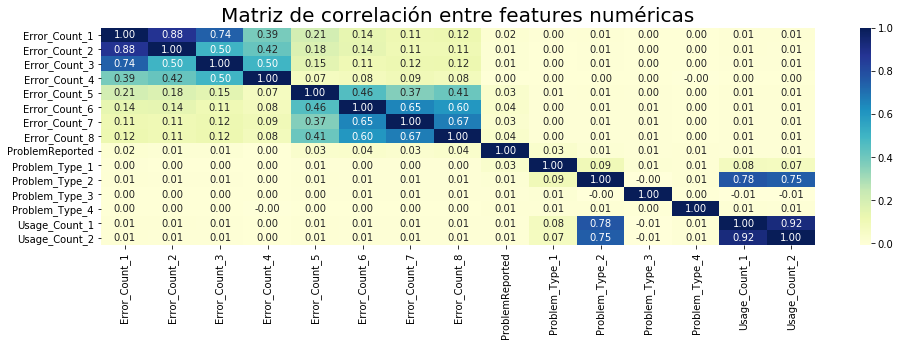

In [11]:
# Visualización de un heatmap con la matriz de correlación entre features numéricas (sin warnings)
df_corr = df[['Error_Count_1', 'Error_Count_2', 'Error_Count_3', 'Error_Count_4',
              'Error_Count_5', 'Error_Count_6', 'Error_Count_7', 'Error_Count_8', 'ProblemReported',
            'Problem_Type_1', 'Problem_Type_2', 'Problem_Type_3', 'Problem_Type_4', 'Usage_Count_1', 'Usage_Count_2']]
corr = df_corr.corr()
plt.figure(figsize = (16,4))
plt.title('Matriz de correlación entre features numéricas', fontsize=20)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap="YlGnBu", annot=True, fmt='.2f')